In [1]:
# Train classifier
# Calculate HOG features
# Perform Sliding Window
# Heatmap
# Label
# Bounding Boxes

In [31]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os, glob, time
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from lesson_functions import *

In [33]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle


In [34]:
car_images_dirs = glob.glob("dataset/vehicles/*")
notcar_images_dirs = glob.glob("dataset/non-vehicles/*")
#car_images_dirs = ['dataset/vehicles/GTI_Far', 'dataset/vehicles/GTI_Left', 'dataset/vehicles/GTI_MiddleClose', 'dataset/vehicles/GTI_Right', 'dataset/vehicles/KITTI_extracted']
#notcar_images_dirs = ['dataset/non-vehicles/Extras', 'dataset/non-vehicles/GTI']
print ("Car Directories: ",car_images_dirs)
print ("Not Car Directories: ",notcar_images_dirs)

Car Directories:  ['dataset/vehicles/GTI_Far', 'dataset/vehicles/GTI_Left', 'dataset/vehicles/GTI_MiddleClose', 'dataset/vehicles/GTI_Right', 'dataset/vehicles/KITTI_extracted']
Not Car Directories:  ['dataset/non-vehicles/Extras', 'dataset/non-vehicles/GTI']


In [42]:
def load_all_images_in(dirs):
    images = []
    all255 = True
    for d in dirs:
        # Get file list
        images_flist = glob.glob(d+"/*")
        print("Found",len(images_flist),"images in",d)
        timeseries_dir = "XXXGTI" in d
        #if timeseries_dir: continue
        
        for i in range(len(images_flist)):
            if timeseries_dir and i % 5 not in [1,3]:
                continue
            f = images_flist[i]
            # cv2 always reads in values 0-255, but as BGR
            new_image = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
            if timeseries_dir and i % 5 == 3:
                new_image = np.fliplr(new_image)
            if np.max(new_image) < 2:
                all255 = False
            images += [new_image]
    if not all255:
        print("WARNING! Got an image that was not 0-255")
    return images
def get_files_in(dirs):
    files = []
    all255 = True
    for d in dirs:
        # Get file list
        images_flist = glob.glob(d+"/*")
        files += images_flist
    return files

# Read in cars and notcars
all_cars = load_all_images_in(car_images_dirs)
all_notcars = load_all_images_in(notcar_images_dirs)
print ("Total Car Images =",len(all_cars))
print ("Total Non-Car Images =",len(all_notcars))


Found 834 images in dataset/vehicles/GTI_Far
Found 909 images in dataset/vehicles/GTI_Left
Found 419 images in dataset/vehicles/GTI_MiddleClose
Found 664 images in dataset/vehicles/GTI_Right
Found 5966 images in dataset/vehicles/KITTI_extracted
Found 5068 images in dataset/non-vehicles/Extras
Found 3900 images in dataset/non-vehicles/GTI
Total Car Images = 8792
Total Non-Car Images = 8968


In [43]:
test_files = glob.glob("test_images/*")
test_images = []
for f in test_files:
    test_images += [mpimg.imread(f)]


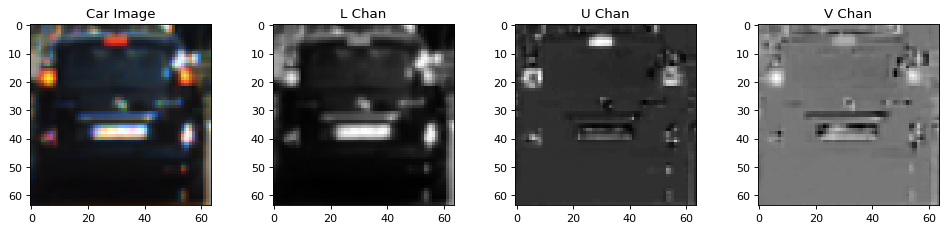

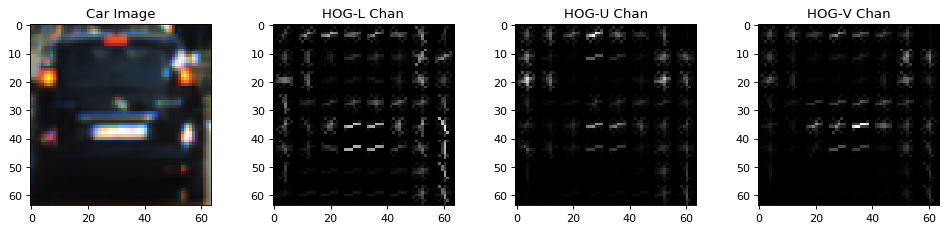

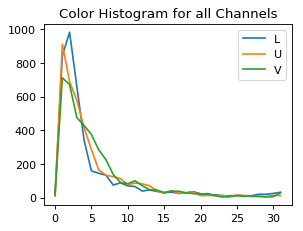

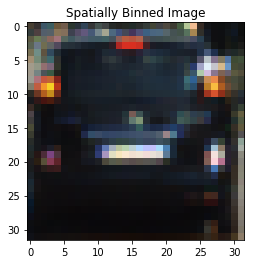

In [171]:

for i in range(10):
    img = all_cars[i]
    img_luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    hog_features,hog_img_l = get_hog_features(img_luv[:,:,0],orient=9,pix_per_cell=8,cell_per_block=8,vis=True)
    hog_features,hog_img_u = get_hog_features(img_luv[:,:,1],orient=9,pix_per_cell=8,cell_per_block=8,vis=True)
    hog_features,hog_img_v = get_hog_features(img_luv[:,:,2],orient=9,pix_per_cell=8,cell_per_block=8,vis=True)
    spatial = bin_spatial(img,size=(32,32))
    hist = color_hist(img,nbins=32)
    multi_graph([img,img_luv[:,:,0],img_luv[:,:,1],img_luv[:,:,2]],["Car Image","L Chan","U Chan","V Chan"])
    multi_graph([img,hog_img_l,hog_img_u,hog_img_v],["Car Image","HOG-L Chan","HOG-U Chan","HOG-V Chan"])
    plt.figure(figsize=(4,3),dpi=80)
    allhist = hist.reshape((3,32))
    plt.plot(allhist[0],label='L')
    plt.plot(allhist[1],label='U')
    plt.plot(allhist[2],label='V')
    plt.legend(loc='upper right')
    plt.title("Color Histogram for all Channels")
    plt.figure()
    plt.imshow(spatial.reshape((32,32,3)))
    plt.title("Spatially Binned Image")
    #print(np.min(all_cars[i]),np.max(all_cars[i]),all_cars[i].shape)
    break

In [45]:
all_cars = shuffle(all_cars)
all_notcars = shuffle(all_notcars)

In [149]:
# Reduce the sample size because
sample_size = 50000
cars = all_cars[0:sample_size]
notcars = all_notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.01)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
12.13 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9848


In [142]:
def get_windows(image):
    y_start_stop1 = [350, 550]
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop1, 
                        xy_window=(64, 64), xy_overlap=(0.4, 0.4))
    y_start_stop2 = [350, 450]
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop2, 
                        xy_window=(32, 32), xy_overlap=(0.5, 0.5))
    y_start_stop3 = [400, 600]
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop3, 
                        xy_window=(112, 112), xy_overlap=(0.1, 0.1))
    
    windows = windows1 + windows2 + windows3
    return windows
windows = get_windows(test_images[0])
heat_map = np.zeros_like(test_images[0])
def box_car_locations(image):
    draw_image = np.copy(image)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    heat_map = np.zeros_like(test_images[0])
    heat_map = add_heat(heat_map, hot_windows)
    #print(np.min(heat_map),np.max(heat_map))
    
    #return heat_map

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    return window_img

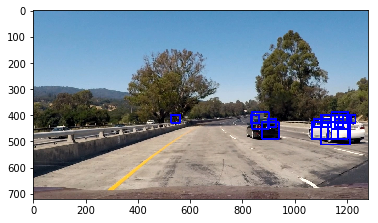

In [143]:
 # Min and max in y to search in slide_window()
for img in test_images:
    
    window_img = box_car_locations(img)
    
    plt.figure()
    plt.imshow(window_img/np.max(window_img),cmap='gray')
    break



In [150]:
from vehicle_tracker import VEHICLE_TRACKER

search_params1 = {"xstart":500,"xstop":1020,"ystart":400,"ystop":500,"scale":1.0}
search_params2 = {"xstart":500,"xstop":1280,"ystart":400,"ystop":600,"scale":2.0}
#search_params3 = {"xstart":500,"xstop":1020,"ystart":400,"ystop":460,"scale":0.5}

search_params = [search_params1,search_params2]
#search_params = [search_params3]
minheat = 35#20

vt = VEHICLE_TRACKER(minheat,search_params, svc, X_scaler, orient,
                            pix_per_cell, cell_per_block, spatial_size, hist_bins,
                            color_space=color_space,hog_channel=hog_channel,spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

def feed_image(img,isVideo=True,returnDict=False):
    res = vt.feed_image(img,isVideo=isVideo)
    if returnDict: return res
    return res["out_img"]




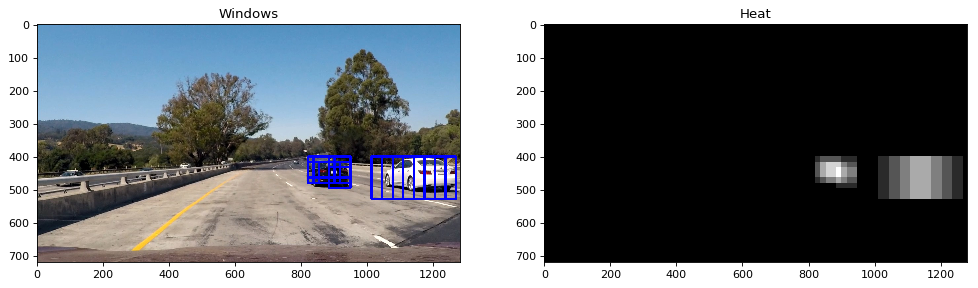

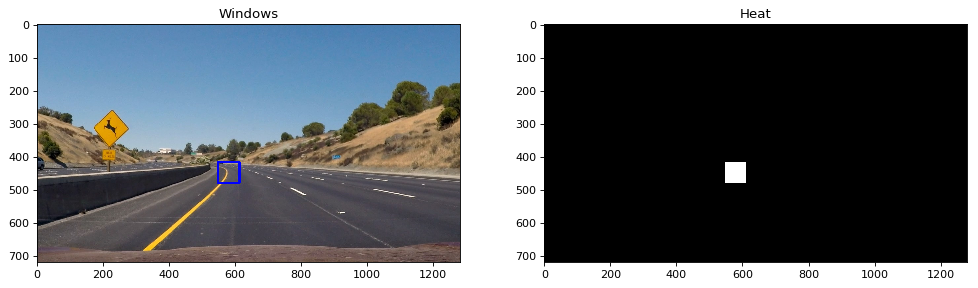

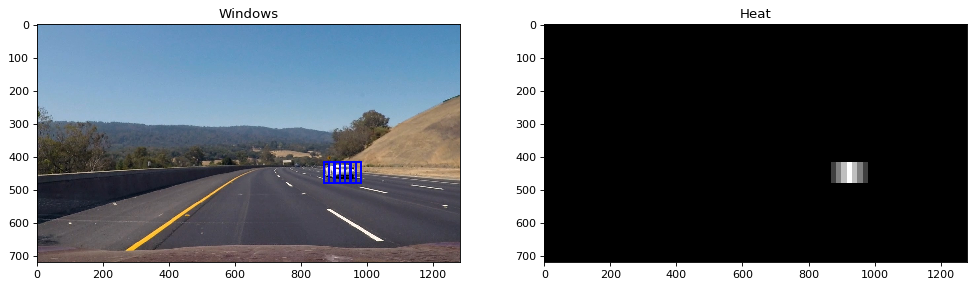

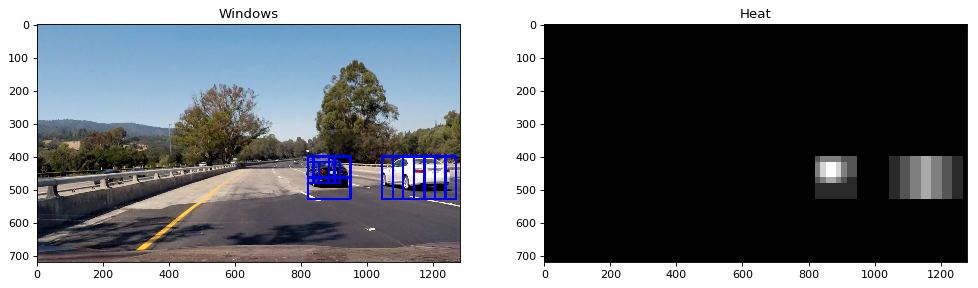

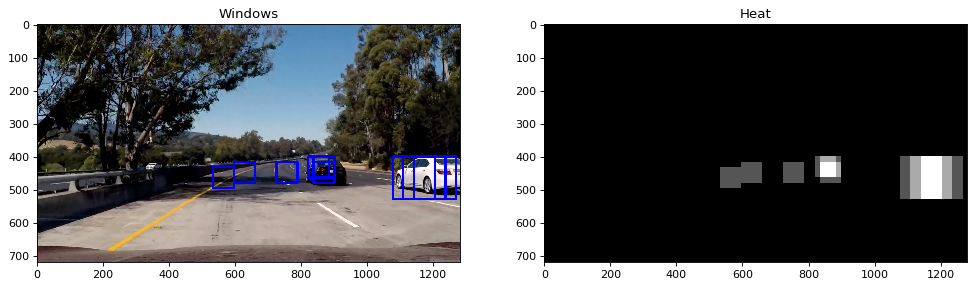

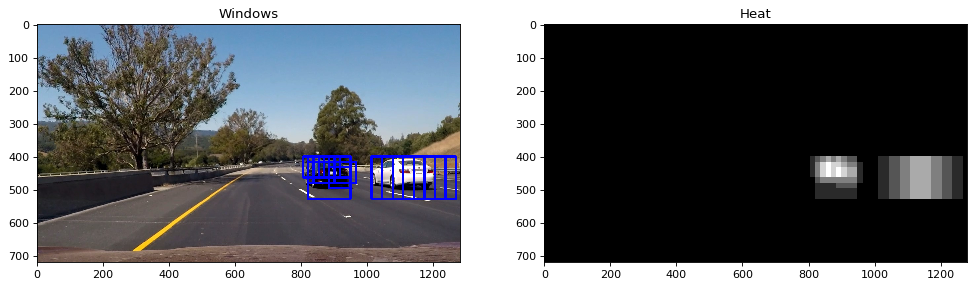

In [155]:
for img in test_images:
    x = feed_image(img,isVideo=False,returnDict=True)
    #multi_graph([img,x["window_img"]],["Original","Windows"],big=True)
    #multi_graph([x["window_img"],x["heat_map"],x["heat_map_thresh"],x["out_img"]],["Windows","Heat","Heat Thresh","Final"])
    multi_graph([x["window_img"],x["heat_map"]],["Windows","Heat"],big=True)

    

In [147]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [151]:
clips = ["test_video","project_video"]
for clipname in clips:
    vt.reset()
    
    movie_output = "output_images/%s_out.mp4" % clipname
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

    clip1 = VideoFileClip("%s.mp4" % clipname)#.subclip(3,7)
    #movie_clip = clip1.fl_image(box_car_locations) #NOTE: this function expects color images!!
    #movie_clip = clip1.fl_image(fast_find) #NOTE: this function expects color images!!
    movie_clip = clip1.fl_image(feed_image) #NOTE: this function expects color images!!
    %time movie_clip.write_videofile(movie_output, audio=False)
    #break

[MoviePy] >>>> Building video output_images/test_video_out.mp4
[MoviePy] Writing video output_images/test_video_out.mp4


 97%|█████████▋| 38/39 [00:04<00:00,  8.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video_out.mp4 

CPU times: user 6.22 s, sys: 68 ms, total: 6.28 s
Wall time: 5.29 s
[MoviePy] >>>> Building video output_images/project_video_out.mp4
[MoviePy] Writing video output_images/project_video_out.mp4


100%|█████████▉| 1260/1261 [02:30<00:00,  8.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_out.mp4 

CPU times: user 3min 23s, sys: 1.44 s, total: 3min 24s
Wall time: 2min 31s
